In [1]:
from matplotlib import pyplot as plt

root_dir = '../data/pd_gy'

path = '../data/pd_gy/train_2.json'

import pandas as pd

import json
with open(path,'r') as f:
    tr_jf = json.load(f)

sample_rate = 300
min5 = sample_rate*60*5

### sample 

In [2]:
tr_jf[0]

{'KEY': '220189079',
 'anesthesia_type': 'general',
 'dept': '부인과',
 'date': 211123,
 'pt_id': 1345625,
 'pt_id_date': '01345625_211123',
 'key': '220189079',
 'rec_path': ['.\\pdrec\\01345625_PDREC03_211123_153100_1.vital'],
 'or_path': ['.\\pdor\\01345625_PDOR2_211123_145500_1.vital'],
 'nrs': '3',
 'age': 38,
 'gender': 'f',
 'nrs2': 0}

In [2]:
import os
idx = 2

recp = tr_jf[idx]['rec_path'][0].replace('\\','/')
recp = os.path.join(root_dir,recp)
orp = tr_jf[idx]['or_path'][0].replace('\\','/')
orp = os.path.join(root_dir, orp)

age = tr_jf[idx]['age']
gender = tr_jf[idx]['gender']

### get x, y

In [131]:
# ppg
import vitaldb
def get_ppg(path,type_='or',sample_rate=sample_rate, duration=min5):
    
    vf = vitaldb.VitalFile(path,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS'])
    ppg = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
    first_idx = 0 
    
    if type_ == 'or':
        nibp_or = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)
        for i, value in enumerate(nibp_or):
            if pd.isna(value):
                continue
            else:
                first_idx = i
                break
                
    elif type_ == 'rec':
        for i, value in enumerate(ppg):
            if pd.isna(value):
                continue
            else:
                first_idx = i
                break
                
    ppg = ppg[first_idx:first_idx+duration]            
    return ppg
                

In [3]:

def get_vital(path,type_='or',sample_rate=sample_rate, duration=min5):
    
    vf = vitaldb.VitalFile(path,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS','Intellivue/ECG_II'])
    ppg = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
    ecg = vf.to_numpy('Intellivue/ECG_II',1/sample_rate)
    first_idx = 0 
    
    if type_ == 'or': # starts from nibp
        nibp_or = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)
        for i, value in enumerate(nibp_or):
            if pd.isna(value):
                continue
            else:
                first_idx = i
                break
                
    elif type_ == 'rec': # starts from non-nan
        for i, value in enumerate(ppg):
            if pd.isna(value):
                continue
            else:
                first_idx = i
                break
    
    ecg = ecg[first_idx:first_idx+duration]            
    ppg = ppg[first_idx:first_idx+duration]            
    return ppg, ecg

In [4]:
# ecg
from dataset import get_vital
ppg_or, ecg_or   = get_vital(orp, type_='or',sample_rate=sample_rate, duration=min5)
ppg_rec, ecg_rec = get_vital(recp, type_='rec',sample_rate=sample_rate, duration=min5)

In [132]:
ppg_or = get_ppg(orp, type_='or')
ppg_rec = get_ppg(recp, type_='rec')

In [133]:
pd.DataFrame(ppg_or[:min5],columns=['ppg']).to_csv('./ppg2.csv')

#### line-by-line 

In [30]:
import vitaldb

# rec ppg
vf = vitaldb.VitalFile(recp,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS'])

ppg = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
# nibp = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)

first_idx = 0 
for i, value in enumerate(ppg):
    if pd.isna(value):
        continue
    else:
        first_idx = i
        break

ppg_rec = ppg[first_idx:first_idx+min5]

# or ppg
vf = vitaldb.VitalFile(orp,track_names=['Intellivue/PLETH','Intellivue/NIBP_SYS'])

ppg_or = vf.to_numpy('Intellivue/PLETH',1/sample_rate)
nibp_or = vf.to_numpy('Intellivue/NIBP_SYS',1/sample_rate)


first_idx = 0 
for i, value in enumerate(nibp_or):
    if pd.isna(value):
        continue
    else:
        first_idx = i
        break

ppg_or = ppg_or[first_idx:first_idx+min5]

## Preprocessing 

### - PPG 

#### interpolate 

In [96]:
from preprocess import interpolate 
ppg_or0 = interpolate(ppg_or)
ppg_rec0 = interpolate(ppg_rec)

### 1. bandpass

In [97]:
from preprocess import bandpass
ppg_or1  = bandpass(ppg_or0, band=[0.5,10],sample_rate=sample_rate)
ppg_rec1 = bandpass(ppg_rec0,band=[0.5,10],sample_rate=sample_rate)

### 2. moving average 

In [98]:
from preprocess import moving_average as ma
ppg_or2 = ma(ppg_or1,w=30)
ppg_rec2 = ma(ppg_rec1,w=30)

### 3. z-score 

In [99]:
from preprocess import norm_z
ppg_or3 = norm_z(ppg_or2)
ppg_rec3 = norm_z(ppg_rec2)

### 4.1 spectrogram 

In [110]:
from scipy import signal
def get_spectrogram(x,fs):
    f, t, xspec = signal.spectrogram(x, fs=fs)
    return xspec

In [102]:
from scipy import signal
f, t, ppg_or4 = signal.spectrogram(ppg_or3, fs=sample_rate)
fr, tr, ppg_rec4 = signal.spectrogram(ppg_rec3, fs=sample_rate)

In [107]:
ppg_or4.shape

(129, 4017)

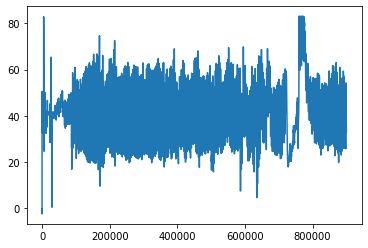

In [105]:
plt.plot(ppg_or2)

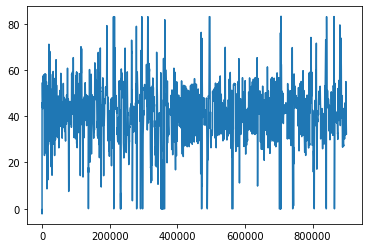

In [106]:
plt.plot(ppg_rec2)

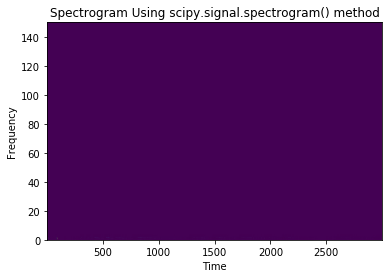

In [103]:
plt.pcolormesh(t, f, ppg_or4,shading='gouraud')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram Using scipy.signal.spectrogram() method')  
plt.show()

In [62]:
import math
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

dt=0.0001
w=2
t=np.linspace(0,5,math.ceil(5/dt))
A=2*(np.sin(1 * np.pi *300* t))

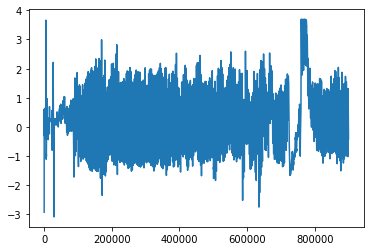

In [76]:
plt.plot(ppg_or3)

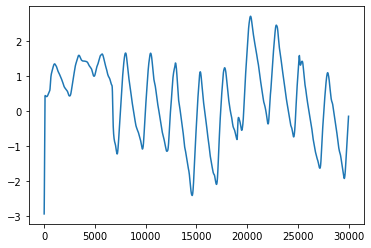

In [80]:
plt.plot(ppg_rec3[:3000*10])

In [63]:
f, t, sxx = signal.spectrogram(ppg_or3, fs=sample_rate)

In [64]:
f.shape,t.shape,sxx.shape

((129,), (4017,), (129, 4017))

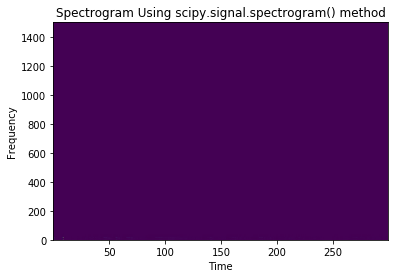

In [65]:
plt.pcolormesh(t, f, sxx,shading='gouraud')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram Using scipy.signal.spectrogram() method')  
plt.show()

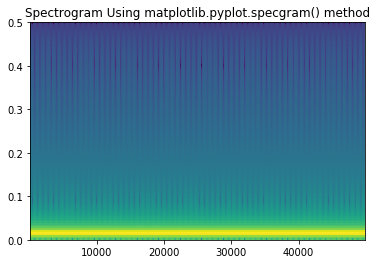

In [29]:
plt.specgram(A,Fs=1)
plt.title('Spectrogram Using matplotlib.pyplot.specgram() method')  
plt.show() 

### 4.2 scalogram 

### - ECG 

### elgendi 

## DT&DL 

## TEST 

In [147]:
import pandas as pd
def get_ppg_sample(idx=0):
    path = f'./sample/ppg{idx}.csv'
    df   = pd.read_csv(path,index_col=0)
    return df.to_numpy()